# Mobility metrics 

This is an exploratory notebook that prototypes a "data good" to help face the covid19 crisis. This project is done under the World Bank's [Data Partnership](https://datapartnership.org/). 

We are guided by the suggestions and pointers given in our covid19 meetings on the subject with experts across the World Bank and external partners.

This "data good" estimates, the mobility of people based on available data. It compares a actual data from Facebook, Google, and Apple. It also points how to recreate these metrics if we have access to raw device-level location.

We have chosen **India** as the example country.

## Setup


If you are running ddp code for the first time, you may need to install the library that includes many helper functions to easy access to partner data.

You need to be a added to the [Github repository](https://github.com/datapartnership/devdatapartnership) to get access. If you cannot see it, you don't have access to install the library. If so, please contact datapartnership@worldbank.org with your Github username to get added to the repository.

```sh
conda create -n ddp python=3
conda activate ddp
/path/to/python -m pip install -e git+ssh://git@github.com/datapartnership/devdatapartnership.git#egg=devdatapartnership
```
Note: You need to restart the kernel to be able to import after install

In [1]:
#import sys ; sys.executable

### Facebook Data

We are going to start with Facebook's new [Movement Range](https://devdatapartnership.herokuapp.com/Facebook.html#Movement-Range-maps) data.

In [2]:
import os
from pathlib import Path

folder=Path("data/mobility")

Since this is still an early release, we get the data on `.csv`s

In [3]:
from glob import glob
fb_data=folder/'FB-mobility'
csvs=[p for p in fb_data.rglob('CSV*/in_gadm*.csv')]
csvs[-1]

PosixPath('data/mobility/FB-mobility/CSVs20200413/in_gadm_mobility_statistics.20200413.csv')

We convert the data into a Pandas DataFrame.

In [4]:
import pandas as pd

rename={'all_day_bing_tiles_visited_relative_change':'r_tiles',
        'all_day_ratio_single_tile_users':'r_tile'}

mov=pd.read_csv(csvs[-1])
mov.rename(columns=rename, inplace=True)
mov['ds']=mov['ds'].apply(pd.Timestamp)
mov = mov.set_index('ds')
mov.head()

,polygon_id,area_type,area_code,polygon_name,country_code,r_tiles,r_tile
ds,,,,,,,
2020-04-08,1132,adm1,IN.TG,Telangana,IN,-0.574119,0.141085
2020-04-08,1113,adm1,IN.JK,Jammu and Kashmir,IN,-0.427373,0.069458
2020-04-12,1132,adm1,IN.TG,Telangana,IN,-0.557866,0.155335
2020-04-12,1110,adm1,IN.GJ,Gujarat,IN,-0.584159,0.107713
2020-04-12,1102,adm1,IN.AR,Arunachal Pradesh,IN,-0.463551,0.055993


There are two kinds of data:
* Mobility Range: The degree of movement, as in the number of map tiles touched by users, relative to a baseline last months.
* Stationary share: The percentage of users always on the same map tile, relative to a baseline last months.


Let's explore first the relation between them on a scatter plot:

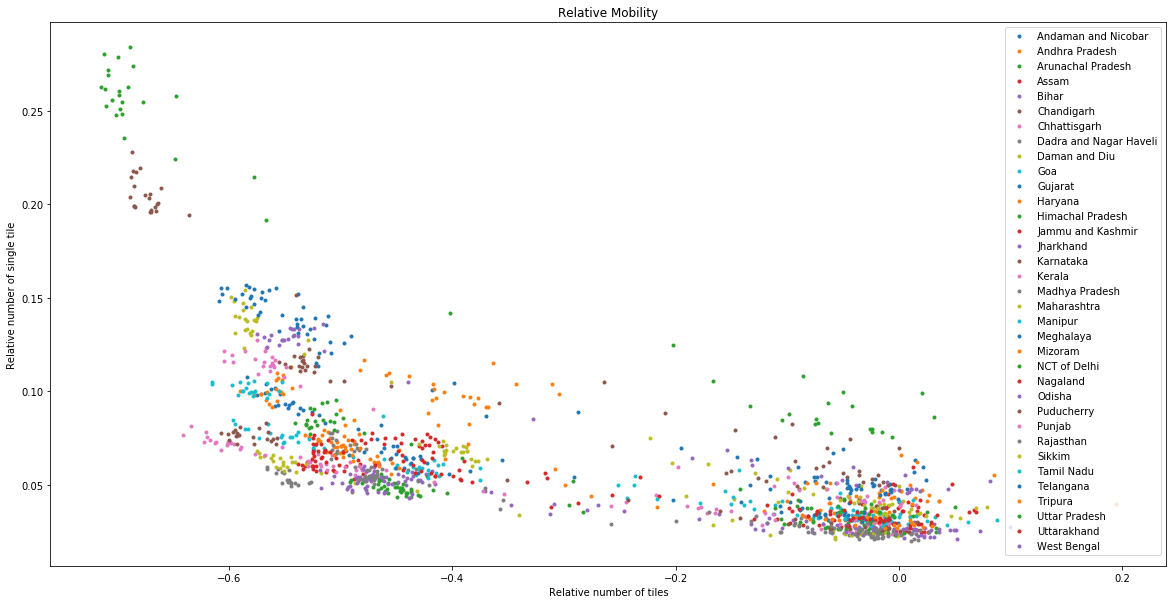

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

groups = mov.groupby('polygon_name')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['r_tiles'], group['r_tile'], marker='.', linestyle='', label=name)
    ax.set_xlabel('Relative number of tiles')
    ax.set_ylabel('Relative number of single tile')
    ax.set_title('Relative Mobility')
ax.legend()

plt.show()

It seems clear, and logical, that there is a proportional relation: The more stationary a region is, the less movement range we see. A higher cluster around `0` (no relative change), means that in these regions, there is more variability of stationary populations.

We also see that some regions tend to be in the same space of the plot, specially the most compliant with the lockdown.

---

#### Mobility range

This data shows the average number of level 16 Bing tiles (0.6km by 0.6km) that a Facebook user (mobile app + location history) was present in during a 24 hour period compared to pre-crisis levels. This is called the Travel Range map.

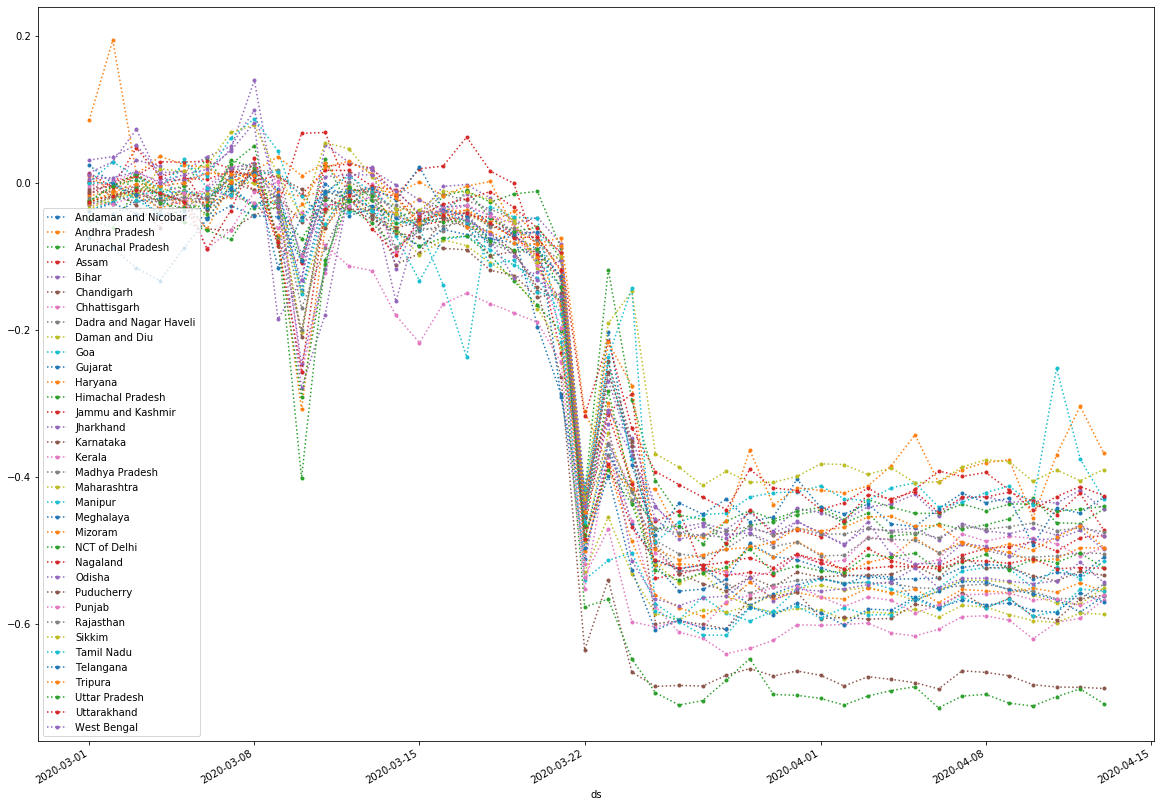

In [6]:
import matplotlib.dates as mdates

ax=mov.groupby('polygon_name')['r_tiles'].plot( marker='.', linestyle=':',figsize=(20, 15));
plt.legend();

ALL regions see a significant decrease in range. The degree of change seems mostly constant, and some places twice than others.

---

#### Stationary share

Percentage of Facebook users (mobile app + location history) that were present in only one such level 16 Bing tile in at least 3 different hours of the day. 

In [7]:
#trick to order by last value
mov.sort_values(by=['r_tile'],ascending=False, inplace=True)

In [8]:
print("The range of value is from %.3f to %.3f"%(mov['r_tile'].min(),mov['r_tile'].max()))

The range of value is from 0.020 to 0.284


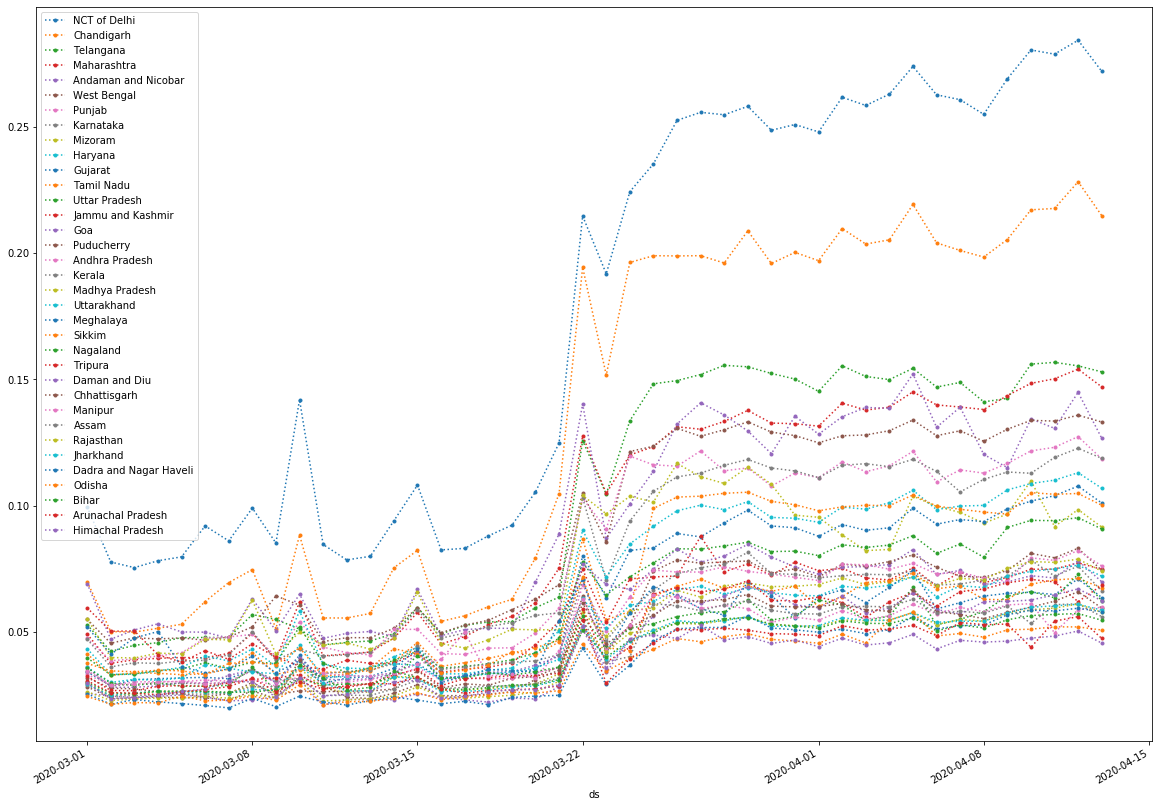

In [9]:
ax=mov.groupby('polygon_name', sort=False)['r_tile'].plot( marker='.', linestyle=':',figsize=(20, 15));
plt.legend()

We see that some regions see little change, while others see `~x15` increase.

---

#### Break up by Indian State

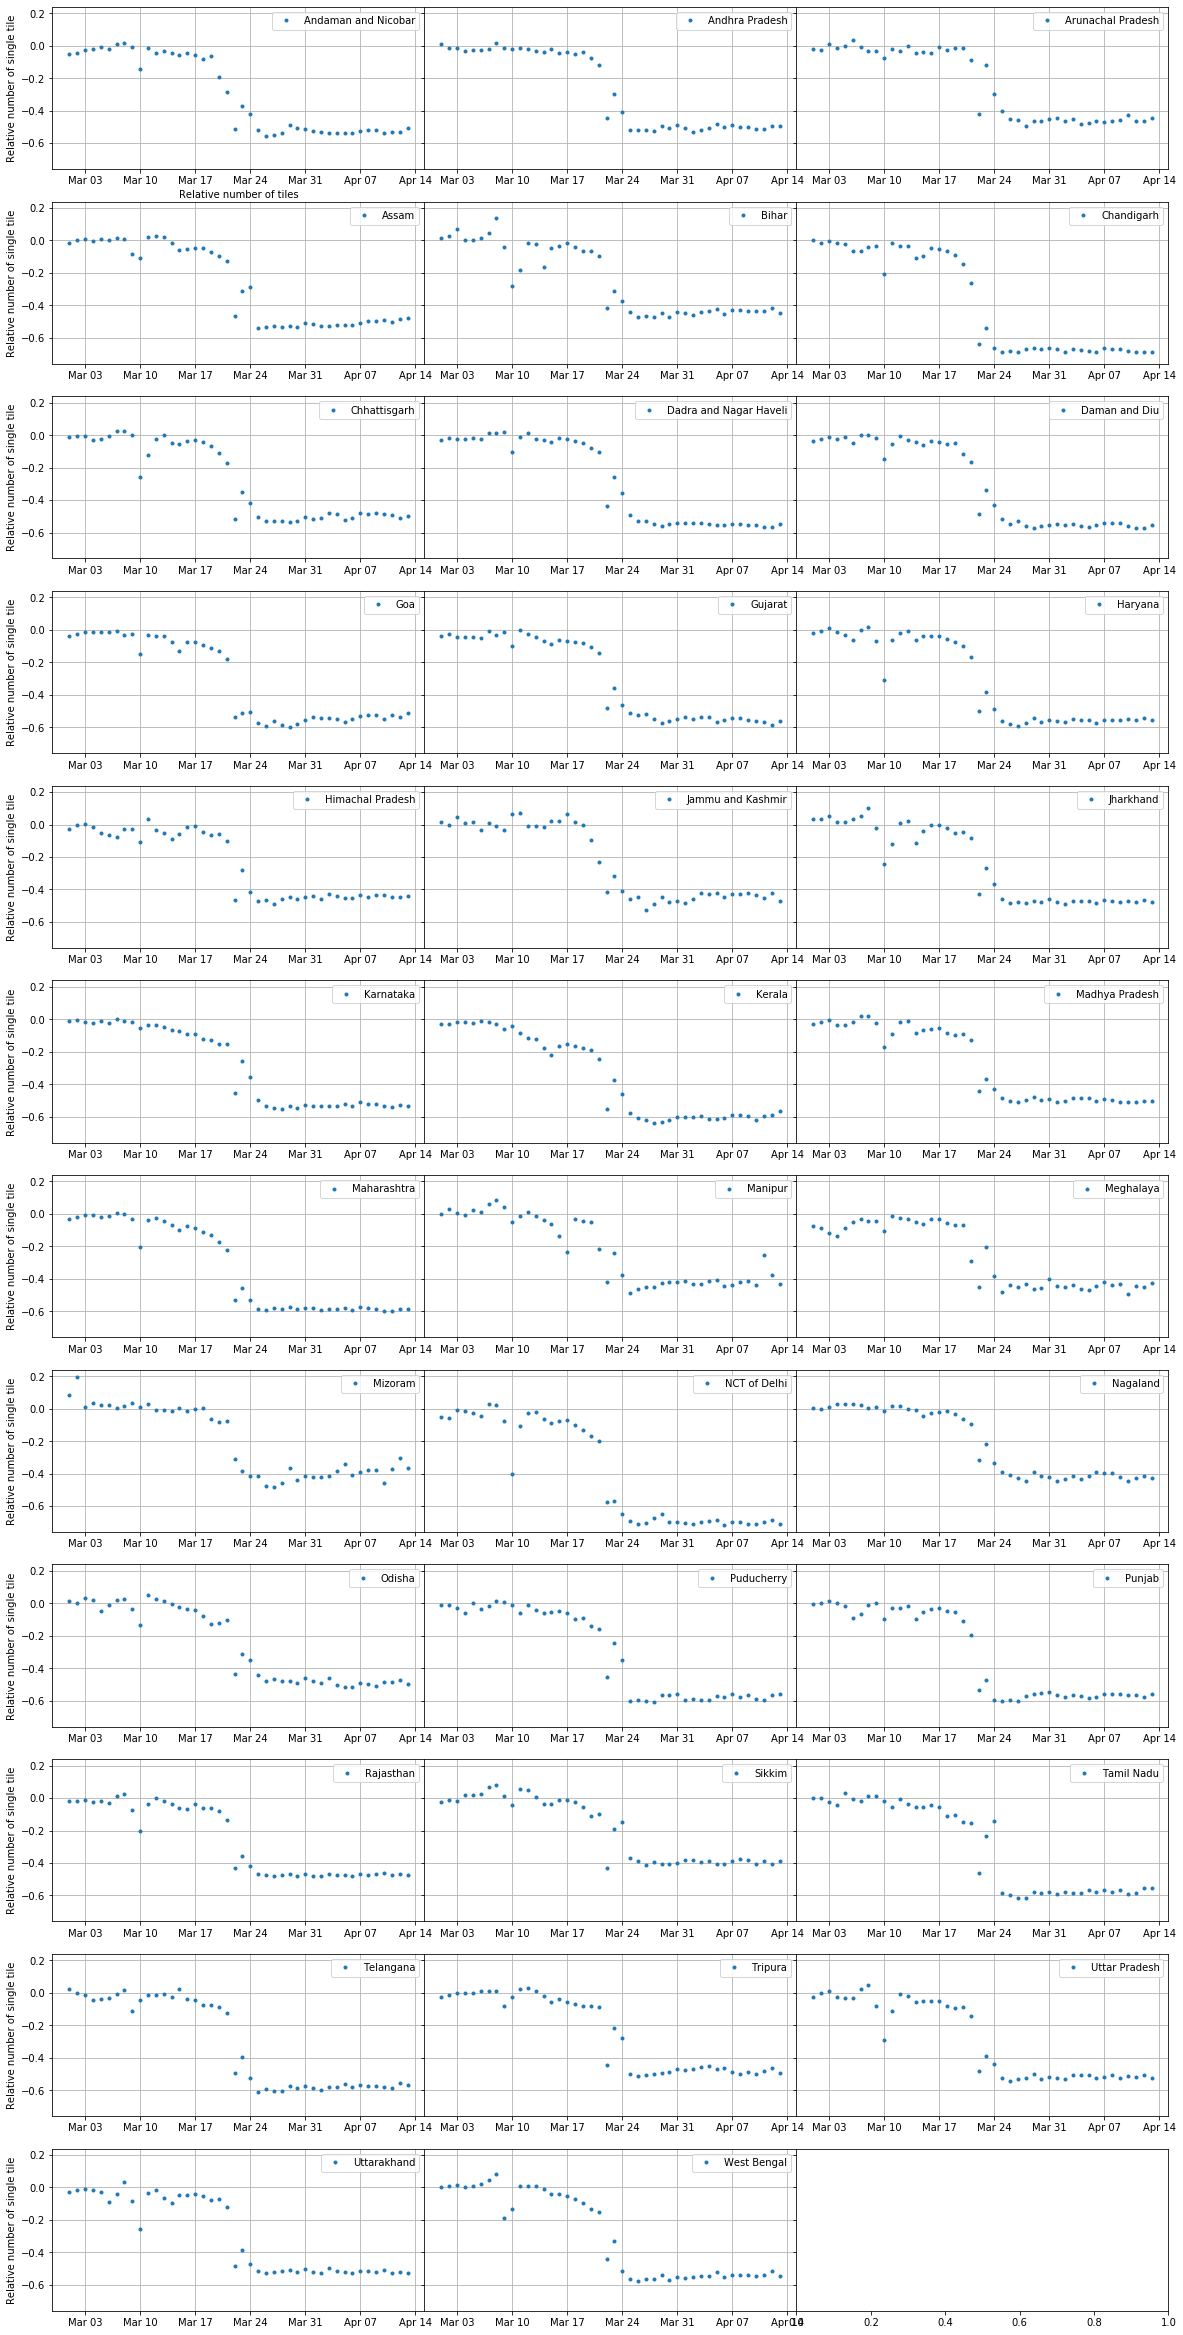

In [10]:
import matplotlib.dates as mdates

groups = mov.groupby('polygon_name')

# Plot
fig, ax = plt.subplots(figsize=(20, 40),nrows=12, ncols=3,sharex=False, sharey=True)
i=0
for name, group in groups:
    row=int(np.floor(i/(ax.shape[1])))
    col=i%(ax.shape[1])
    i=i+1
    #print(i,row,col)
    ax[row,col].plot(group['r_tiles'], marker='.', linestyle='', label=name)
    ax[row,col].margins(0.05)
    ax[0,0].set_xlabel('Relative number of tiles')
    ax[row,0].set_ylabel('Relative number of single tile')
    ax[row,col].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[row,col].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax[row,col].grid(True)
    ax[row,col].legend()

plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0,hspace = 0.2)
plt.show()

### Apple Data

In [11]:
from glob import glob
apple_data=[p for p in folder.rglob('apple*.csv')]
apple_data

[PosixPath('data/mobility/applemobilitytrends-2020-04-17.csv')]

In [12]:
apple_mov=pd.read_csv(apple_data[-1])
apple_mov=apple_mov[apple_mov['region']=='India']

In [13]:
apple_mov=apple_mov[apple_mov.columns[2:]].T
rename={56:'A-driving',
        57:'A-walking'}
apple_mov.rename(columns=rename, inplace=True)
apple_mov=apple_mov.iloc[1:]
apple_mov.head()

,A-driving,A-walking
2020-01-13,100,100
2020-01-14,102.35,99.18
2020-01-15,107.96,104.08
2020-01-16,110.77,107.41
2020-01-17,120.64,113.91


In [14]:
apple_mov.index = pd.to_datetime(apple_mov.index,format='%Y-%m-%d')

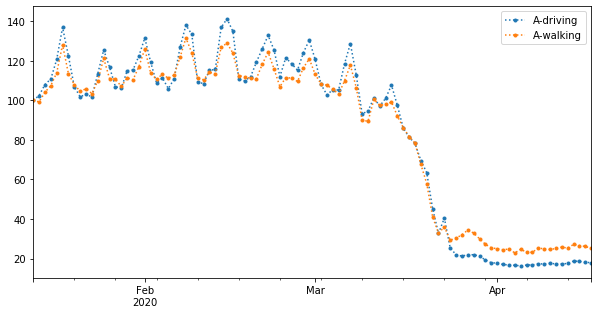

In [15]:
apple_mov.plot(marker='.', linestyle=':',figsize=(10, 5))

### Google Data

In [16]:
from glob import glob
google_data=[p for p in folder.rglob('Google*.csv')]
google_data

[PosixPath('data/mobility/Google-Global_Mobility_Report.csv')]

In [17]:
google_mov=pd.read_csv(google_data[-1])
google_mov=google_mov[google_mov['country_region']=='India']
google_mov=google_mov[google_mov.columns[4:]]

rename={'retail_and_recreation_percent_change_from_baseline':'G-retail',
       'grocery_and_pharmacy_percent_change_from_baseline':'G-grocery',
       'parks_percent_change_from_baseline':'G-parks',
       'transit_stations_percent_change_from_baseline':'G-transit',
       'workplaces_percent_change_from_baseline':'G-workplaces',
       'residential_percent_change_from_baseline':'G-residential'}
google_mov.rename(columns=rename, inplace=True)
google_mov['date']=google_mov['date'].apply(pd.Timestamp)
google_mov = google_mov.set_index('date')
google_mov.head()

/Users/brunosan/anaconda3/envs/ddp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,G-retail,G-grocery,G-parks,G-transit,G-workplaces,G-residential
date,,,,,,
2020-02-15,1.0,2.0,3.0,3.0,5.0,0.0
2020-02-16,2.0,2.0,3.0,2.0,0.0,0.0
2020-02-17,-1.0,1.0,3.0,1.0,4.0,0.0
2020-02-18,0.0,2.0,4.0,2.0,3.0,0.0
2020-02-19,0.0,2.0,1.0,1.0,4.0,1.0


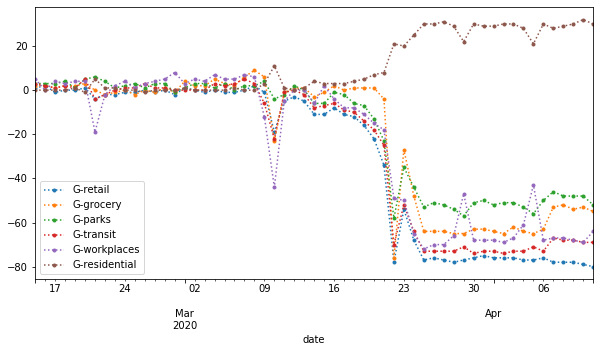

In [18]:
google_mov.plot(marker='.', linestyle=':',figsize=(10, 5))

### Cross comparison

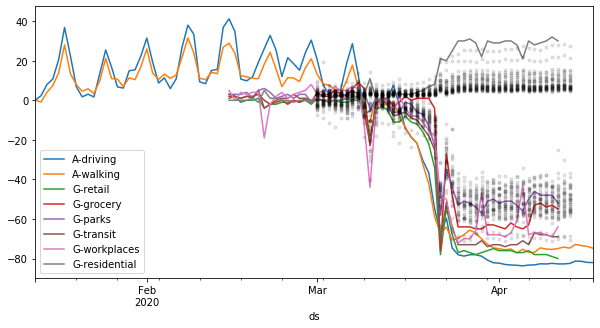

In [19]:
ax = (apple_mov-100).plot(figsize=(10, 5))
(google_mov).plot(ax=ax)
(mov*100).groupby('polygon_name')['r_tile'].plot(ax=ax,marker='.', linestyle='',color='black',alpha=0.1);
(mov*100).groupby('polygon_name')['r_tiles'].plot(ax=ax,marker='.', linestyle='',color='black',alpha=0.1);

## Pipeline

## marketplace traffic

This explores how to recreate the above metrics, if you have device-level data.
As an example, we are using real locations of `markets` in Kolkata, India (from OSM), and then creating fake device level data just using random points at random times.

We get the locations of real `amenity=marketplace` from OSM

In [20]:
import geopandas as gpd
marketplace_file=folder/'Kolkata-marketplace.geojson'
markets = gpd.read_file(marketplace_file).to_crs('epsg:3857')
markets['geometry'] = markets['geometry'].centroid

There are 31 markets in the area


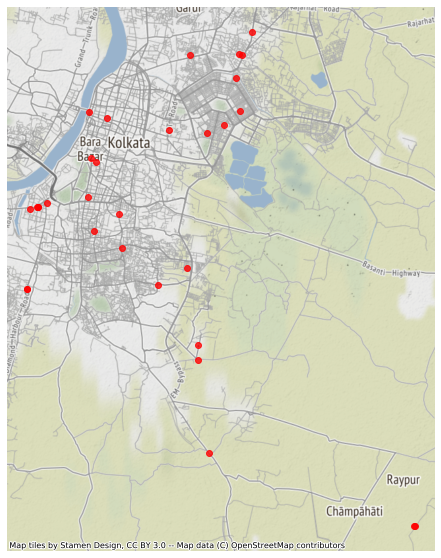

In [21]:
import contextily as ctx

ax = markets.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)
ax.set_axis_off()
print("There are %i markets in the area"%len(markets))

Then we add a buffer of 500m around them so we assign any device-level ping as a visit to the market.

In [22]:
#add a 500m buffer
markets_zones=markets
markets_zones.geometry=markets.geometry.buffer(500)

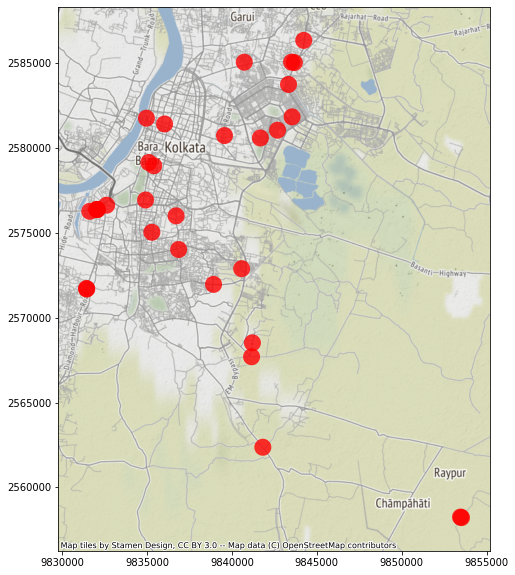

In [23]:
ax = markets.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)

In order to make random times between 2 dates, we need a bit of code.

In [24]:
#random dates

import random
import time

def strTimeProp(start, end, format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formated in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def randomDate(start, end, prop):
    return strTimeProp(start, end, '%d/%m/%Y %I:%M %p', prop)

randomDate("1/1/2008 1:30 PM", "1/1/2009 4:50 AM", random.random())

'02/10/2008 12:11 PM'

Now we create the random points within the same Kolkata area, at random places, at random times.

In [40]:
#create synthtetic data
import numpy as np
from shapely.geometry import Point

xmin, ymin, xmax,  ymax = markets.total_bounds
num_points = 200000
xc = (xmax - xmin) * np.random.random(num_points) + xmin
yc = (ymax - ymin) * np.random.random(num_points) + ymin
tc = [randomDate("4/1/2020 1:01 AM", "20/4/2020 04:50 AM", random.random()) for i in np.empty(num_points)]
points_geom = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
points = gpd.GeoDataFrame(pd.DataFrame({'time':tc}),geometry=points_geom, crs=markets.crs)
points.crs = markets.crs
points.head()

,time,geometry
0,27/03/2020 11:12 PM,POINT (9846523.452 2569225.660)
1,14/02/2020 12:47 AM,POINT (9849244.553 2574477.888)
2,19/04/2020 07:03 AM,POINT (9838043.423 2570546.587)
3,12/01/2020 07:46 AM,POINT (9845584.386 2570698.848)
4,10/01/2020 08:07 PM,POINT (9837472.667 2558766.304)


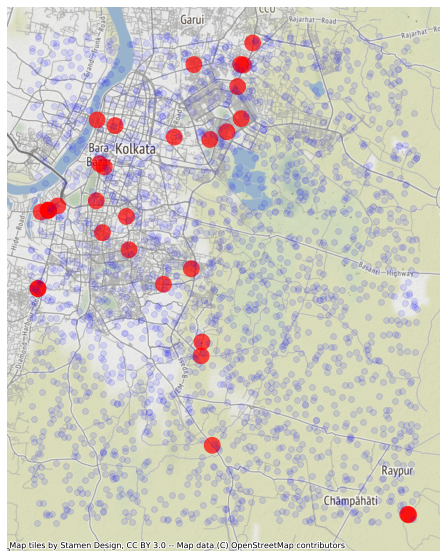

In [48]:
ax =  markets.plot(figsize=(10, 10), alpha=.7,color='red')
points.sample(n=int(num_points/100)).plot(ax=ax, alpha=0.1,color='blue')

ctx.add_basemap(ax)
ax.set_axis_off()

With a Spatial join, we can now filter out any point not intersecting our buffered marketplaces.

In [42]:
inside=gpd.sjoin(points, markets, how='left',)
inside=inside[inside.notnull()['id']]
inside.head()

,time,geometry,index_right,id,@id,amenity,building,name,operator,type,...,addr:postcode,addr:street,leisure,alt_name,alt_name:short,name:en,short_name,opening_hours,designation,description
53,05/01/2020 08:48 AM,POINT (9836042.483 2581237.706),28.0,node/6173706994,node/6173706994,marketplace,None,None,None,None,...,None,None,None,None,None,None,None,None,None,fruit market
102,04/03/2020 11:25 AM,POINT (9831341.945 2576361.854),4.0,way/142718051,way/142718051,marketplace,commercial,Babu Bazar,None,None,...,700023,Bhukaliash Road,None,None,None,None,None,None,None,None
172,17/03/2020 11:44 AM,POINT (9843803.527 2581445.495),5.0,way/156164648,way/156164648,marketplace,None,CK Market,None,None,...,None,None,marketplace,None,None,None,None,None,None,None
177,18/02/2020 10:00 PM,POINT (9831091.277 2571589.652),16.0,way/396486017,way/396486017,marketplace,yes,Hawkers' Corner,None,None,...,None,None,None,None,None,None,None,None,None,None
177,18/02/2020 10:00 PM,POINT (9831091.277 2571589.652),24.0,node/1659494613,node/1659494613,marketplace,None,Behala Market,None,None,...,None,None,None,None,None,None,None,None,Marketplace,None


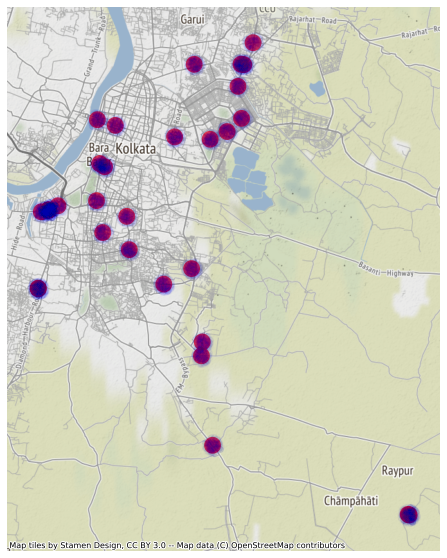

In [49]:
ax =  markets.plot(figsize=(10, 10), alpha=.7,color='red')
inside.plot(ax=ax, alpha=0.01,color='blue')

ctx.add_basemap(ax)
ax.set_axis_off()

In order to plot the time series by daily bins, we need a bit of code

In [50]:
#make the string into a datetime 
inside['time'] = pd.to_datetime(inside['time'], format='%d/%m/%Y %I:%M %p')
inside['time'].head()

53    2020-01-05 08:48:00
102   2020-03-04 11:25:00
172   2020-03-17 11:44:00
177   2020-02-18 22:00:00
177   2020-02-18 22:00:00
Name: time, dtype: datetime64[ns]

In [51]:
inside['day']=pd.to_datetime(inside['time'], format='%d/%m/%Y').dt.strftime('%m/%d/%Y')

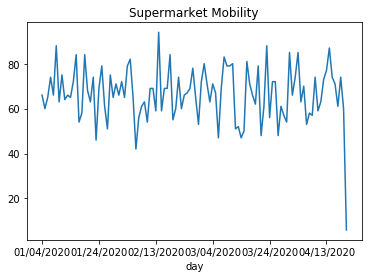

In [52]:
ax = inside.groupby('day').count()['time'].plot()
ax.set_title('Supermarket Mobility');